## Plant Leaf Classifier Module

This module helps to identifiy the diseases in the plant based on the images of the leaves of the plant.
It uses the convolutional neural network to classify the images of the leaves based on  the type of disease or if it is healthy.


### Import Header

In [45]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch import nn
from torch.autograd import Variable
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
import gc
import sys
import math

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import multilabel_confusion_matrix
from torchsummary import summary

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from matplotlib.ticker import MultipleLocator


In [2]:
BATCH_SIZE = 64
DATASET_PATH = '../data/Plant_leaf_diseases_dataset_with_augmentation'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
curr_dir = os.getcwd()
root = os.path.join(curr_dir, DATASET_PATH)
MODEL_PATH = os.path.join(curr_dir, "model1.pth")

#### Load Data ####

In [3]:
file_names = []
for path, subdirs, files in os.walk(root):
    for name in files:
        file_names.append(os.path.join(path, name))

In [4]:
def load_images(files):
    images = []
    for name in files:
        image = cv2.imread(name)
        image = cv2.resize(image, (128,128))
        images.append(image)
    return np.asarray(images)

In [5]:
images = load_images(file_names)

In [6]:
labels = [ x.split('\\')[-2] for x in file_names ]
unique_labels, label_count = np.unique(labels, return_counts=True)
unique_label_dict = { x : i for i,x in enumerate(unique_labels) }
labels_int = torch.tensor(np.array([unique_label_dict[l] for l in labels]), dtype=torch.long)

In [7]:
images_idx = np.array([ i for i in range(len(images))])

#### Class distribution of Data ####

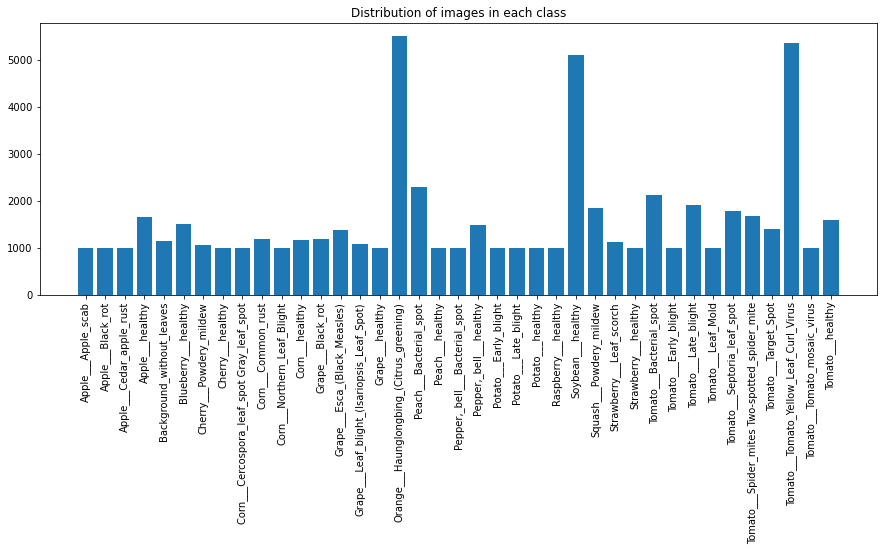

In [89]:

fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.set_title("Distribution of images in each class")
ax1.bar(x=range(len(unique_labels)), height=label_count, tick_label=unique_labels)
ax1.set_xticklabels(unique_labels, rotation=90)
plt.show()

#### Split data to Train and Test ####

In [9]:
X_train, X_test, y_train, y_test = train_test_split(images_idx, labels_int, test_size=0.2, stratify=labels_int)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)
print(" Size of Train set:", len(X_train),
      "\n Size of Test set:", len(X_test),
      "\n Size of Validation set:", len(X_val) )

 Size of Train set: 39350 
 Size of Test set: 12298 
 Size of Validation set: 9838


#### Data Augmentation ####

From the graph we can see that there are few classes that has more data than the others. This creates a class imbalance.
To avoid this, the images of other classes are augmented to increase the count.

In [10]:
def make_classes_equal (X, Y):
    lbl_index = []
    output_index = []
    maxLength = 0
    minLength = len(Y)
    
    # Get all the indexs for each class
    for s in unique_label_dict.values():
        lbl_index.append((np.where(Y == s))[0])
        if len(lbl_index[-1]) > maxLength:
            maxLength = len(lbl_index[-1])
        if len(lbl_index[-1]) < minLength:
            minLength = len(lbl_index[-1])

    required_length = int((maxLength + minLength)/2)
    
    # Make the number of index for all the classes equal
    for i,l in enumerate(lbl_index):
        n = int(required_length / len(l))
        d = required_length % len(l)
        output_index = output_index + list(l) * n + list(l[: d])

    out_y = Y[output_index]
    out_x = X[output_index]
    
    return out_x, out_y

In [11]:
X_train, y_train = make_classes_equal(X_train, y_train)
X_test, y_test = make_classes_equal(X_test, y_test)
X_val, y_val = make_classes_equal(X_val, y_val)

In [12]:
print(" Size of Train set:", len(X_train), len(y_train),
      "\n Size of Test set:", len(X_test), len(y_test),
      "\n Size of Validation set:", len(X_val), len(y_val))

 Size of Train set: 81198 81198 
 Size of Test set: 25389 25389 
 Size of Validation set: 20280 20280


#### Data Loader ####

In [13]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.8, 1.2))
    image = brightness.augment_image(image)
    return image

def img_contrast(image):
    contrast = iaa.LinearContrast((0.8, 1.2))
    image = contrast.augment_image(image)
    return image

def random_augment(image, prob=0.5):
    image = np.array(torch.from_numpy(image).permute(1, 2, 0))
    if np.random.rand() < prob:
        image = img_contrast(image)
    if np.random.rand() < prob:
        image = img_random_brightness(image)
    return np.transpose(image,(2,0,1))

    
data_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

ConvertToTensor = transforms.ToTensor()


In [15]:
class PlantLeafDataset(Dataset):
    def __init__(self, labels, imgs_idx, transform=None):
        self.labels = labels
        self.images_idx = imgs_idx
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img = images[self.images_idx[idx]]
        label = self.labels[idx]
        
        if self.transform:
            img = random_augment(images[self.images_idx[idx]])
            img = self.transform(img)
        else:
            img = ConvertToTensor(img)

        return (img, label)


In [16]:
plant_train_dataset = PlantLeafDataset(labels=y_train,
                                       imgs_idx=X_train,
                                       transform=data_transform)

plant_validation_dataset = PlantLeafDataset(labels = y_val,
                                            imgs_idx = X_val,
                                            transform=data_transform)
plant_test_dataset = PlantLeafDataset(labels = y_test,
                                      imgs_idx = X_test,
                                      transform=data_transform)

train_dataloader = DataLoader(plant_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(plant_validation_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(plant_test_dataset, batch_size=BATCH_SIZE)

In [101]:
def show_lables(ax, image):
    ax.imshow(image)
#     ax.pause(0.001)

Apple___Apple_scab


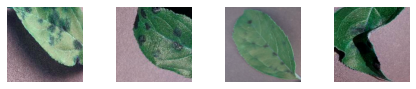

In [104]:
fig, ax = plt.subplots(1,4)


ConvertTensorToPIL = transforms.ToPILImage()

for i in range(len( plant_train_dataset)):
    img, lbl = plant_train_dataset[i]
    plt.tight_layout()
#     ax[i].set_title( 'Sample #{} - {}'.format( i, unique_labels[lbl]))
    ax[i].axis('off')
    show_lables(ax[i], ConvertTensorToPIL( img ) )


    if i == 3:
        print(unique_labels[lbl])
        plt.show()
        break

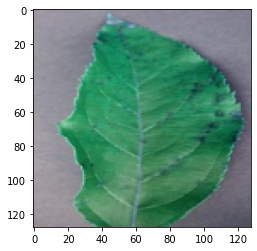

In [20]:
img = images[0]
img = aug_combo(img)
plt.imshow(img/255)
plt.show()

#### Defining the Convalutional Neural Network Model ####

In [132]:
class ConvNN_Model(nn.Module):
    def __init__(self):
        num_inputs=3
        num_outputs=39
        super(ConvNN_Model, self).__init__()
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(in_channels=num_inputs, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(p=0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.layer3 = torch.nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout(p=0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),

        )
        
        self.layer4 = torch.nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.fc1 = torch.nn.Sequential(
            nn.Linear(512 * 6 * 6, 4096, bias=True),
            nn.Sigmoid())
        self.fc2 = torch.nn.Sequential(
            nn.Linear(4096, 1024, bias=True),
            nn.Sigmoid())
        self.fc3 = torch.nn.Sequential(
            nn.Linear(1024, num_outputs, bias=True),
            nn.Softmax(dim=1))
        

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [138]:
model = ConvNN_Model()
summary(model.cuda(), (3,128,128), 64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 64, 126, 126]           1,792
              ReLU-2         [64, 64, 126, 126]               0
       BatchNorm2d-3         [64, 64, 126, 126]             128
         MaxPool2d-4           [64, 64, 63, 63]               0
            Conv2d-5          [64, 128, 61, 61]          73,856
              ReLU-6          [64, 128, 61, 61]               0
       BatchNorm2d-7          [64, 128, 61, 61]             256
           Dropout-8          [64, 128, 61, 61]               0
         MaxPool2d-9          [64, 128, 30, 30]               0
           Conv2d-10          [64, 256, 28, 28]         295,168
             ReLU-11          [64, 256, 28, 28]               0
      BatchNorm2d-12          [64, 256, 28, 28]             512
          Dropout-13          [64, 256, 28, 28]               0
        MaxPool2d-14          [64, 256,

#### Train the  Model ###

##### Define the parameters #####

In [48]:
learning_rate = 0.0001
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
training_epochs = 10

In [49]:
def print_progress(pos, total, bins=50, before_msg=None, after_msg=None):

    bar = '[' + '#'*int((pos/total) * bins) + '-'*(bins - int((pos/total) * bins)) + ']'
    if not before_msg: before_msg = ''
    if not after_msg: after_msg = ''
    msg = f'\r{before_msg} {pos}/{total} {bar} {after_msg}  '
    if pos==total:
        print(msg)
    else:
        print(msg, end='  ')
        sys.stdout.flush()

###### Training the Model ######

In [51]:
print('Training the Deep Learning network ...')
print('Using {} device'.format(DEVICE))

bestValScore = 0

train_cost = []
train_accu = []
val_cost = []
val_accu = []

y_train_pred = []
y_train_true = []
y_val_pred = []
y_val_true = []

train_f1_scores = []
train_precisions = []
train_recalls = []

val_f1_scores = []
val_precisions = []
val_recalls = []

total_batch_train = int(math.floor(len(X_train) / BATCH_SIZE ))
total_batch_val = int(math.floor(len(X_val) / BATCH_SIZE ))

model = model.to(DEVICE)

for epoch in range(training_epochs):
    avg_cost = 0
    
    # Training Model
    print("\nTraining:")
    model.train()
    for i, (batch_X, batch_Y) in enumerate(train_dataloader):

        X = Variable(batch_X).to(DEVICE)
        Y = Variable(batch_Y).to(DEVICE)
        
        optimizer.zero_grad()    
        hypothesis = model(X)
        cost = criterion(hypothesis, Y) 
        cost.backward()      
        optimizer.step()
             
        prediction = hypothesis.argmax(dim=1)  
        y_train_pred = y_train_pred + list(prediction.to("cpu"))
        y_train_true = y_train_true + list(Y.to("cpu"))
        
        avg_cost += cost.data.item()
        
        print_progress(i, total_batch_train, bins=50, before_msg="Epoch %d : "%(epoch+1), after_msg=None)
    
    del X, Y
    gc.collect()
    torch.cuda.empty_cache()    
    
    train_accu.append(((torch.tensor(y_train_pred) == torch.tensor(y_train_true)).float().mean()).item())
    train_cost.append(avg_cost/total_batch_train)
    train_f1_scores.append(f1_score(y_train_true, y_train_pred, average="macro"))
    train_precisions.append(precision_score(y_train_true, y_train_pred, average="macro"))
    train_recalls.append(recall_score(y_train_true, y_train_pred, average="macro"))
    
    y_train_pred.clear()
    y_train_true.clear()
        
    avg_cost = 0
    
    print("\nValidating:")
    # Validating Model
    model.eval()
    for i, (Xval,Yval) in enumerate(validation_dataloader):
        with torch.no_grad():
            X = Variable(Xval).to(DEVICE)
            Y = Variable(Yval).to(DEVICE)

            hypothesis = model(X)
            cost = criterion(hypothesis, Y)

            prediction = hypothesis.argmax(dim=1)
            y_val_pred = y_val_pred + list(prediction.to("cpu"))
            y_val_true = y_val_true + list(Yval.to("cpu"))
            
            avg_cost += cost.data.item()
            
        print_progress(i, total_batch_val, bins=50, before_msg="Epoch %d : "%(epoch+1), after_msg=None)
        
    del X, Y
    gc.collect()
    torch.cuda.empty_cache()
    
    val_accu.append(((torch.tensor(y_val_pred) == torch.tensor(y_val_true)).float().mean()).item())
    val_cost.append(avg_cost/total_batch_val)
    val_f1_scores.append(f1_score(y_val_true, y_val_pred, average="macro"))
    val_precisions.append(precision_score(y_val_true, y_val_pred, average="macro"))
    val_recalls.append(recall_score(y_val_true, y_val_pred, average="macro"))
    y_val_pred.clear()
    y_val_true.clear()
    
    if bestValScore < val_accu[-1]:
        bestValScore = val_accu[-1]
        torch.save(model, MODEL_PATH)

    print("\nEpoch= {},\t train cost = {:2.4f},\t train accuracy = {:2.4f},\t val cost = {:2.4f},\t val accuracy = {:2.4f}".format(epoch+1, train_cost[-1], train_accu[-1],val_cost[-1], val_accu[-1] ))

#     if (epoch+1)%5 == 0:
#         for g in optimizer.param_groups:
#             g['lr'] = 0.01/(epoch/5 + 1) 

#     print("\n[Epoch: {:>4}], averaged cost = {:>.9}".format(epoch + 1, avg_cost))

print('Learning Finished!')

Training the Deep Learning network ...
Using cuda device

Training:


C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (128, 3, 128) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


Epoch 1 :  1268/1268 [##################################################]      


C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Validating:
Epoch 1 :  0/316 [--------------------------------------------------]     

C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (128, 3, 128) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


Epoch 1 :  316/316 [##################################################]              


C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch= 1,	 train cost = 3.1324,	 train accuracy = 0.5876,	 val cost = 3.1330,	 val accuracy = 0.6056

Training:


C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (128, 3, 128) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


Epoch 2 :  1268/1268 [##################################################]                


C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Validating:
Epoch 2 :  0/316 [--------------------------------------------------]     

C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (128, 3, 128) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


Epoch 2 :  316/316 [##################################################]     


C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch= 2,	 train cost = 2.9933,	 train accuracy = 0.7263,	 val cost = 3.0180,	 val accuracy = 0.7142

Training:


C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (128, 3, 128) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


Epoch 3 :  1268/1268 [##################################################]       


C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Validating:
Epoch 3 :  0/316 [--------------------------------------------------]     

C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (128, 3, 128) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


Epoch 3 :  316/316 [##################################################]     


C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch= 3,	 train cost = 2.8864,	 train accuracy = 0.8325,	 val cost = 2.9333,	 val accuracy = 0.7947

Training:


C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (128, 3, 128) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


Epoch 4 :  1268/1268 [##################################################]          


C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Validating:
Epoch 4 :  0/316 [--------------------------------------------------]     

C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (128, 3, 128) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


Epoch 4 :  316/316 [##################################################]     


C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch= 4,	 train cost = 2.8450,	 train accuracy = 0.8705,	 val cost = 2.8726,	 val accuracy = 0.8581

Training:


C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (128, 3, 128) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


Epoch 5 :  1268/1268 [##################################################]              

Validating:
Epoch 5 :  0/316 [--------------------------------------------------]     

C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (128, 3, 128) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


Epoch 5 :  316/316 [##################################################]     

Epoch= 5,	 train cost = 2.7808,	 train accuracy = 0.9359,	 val cost = 2.8202,	 val accuracy = 0.9082

Training:


C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (128, 3, 128) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


Epoch 6 :  1268/1268 [##################################################]            

Validating:
Epoch 6 :  0/316 [--------------------------------------------------]     

C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (128, 3, 128) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


Epoch 6 :  316/316 [##################################################]      

Epoch= 6,	 train cost = 2.7290,	 train accuracy = 0.9852,	 val cost = 2.7754,	 val accuracy = 0.9485

Training:


C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (128, 3, 128) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


Epoch 7 :  1268/1268 [##################################################]          

Validating:
Epoch 7 :  0/316 [--------------------------------------------------]     

C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (128, 3, 128) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


Epoch 7 :  316/316 [##################################################]     

Epoch= 7,	 train cost = 2.7226,	 train accuracy = 0.9897,	 val cost = 2.7922,	 val accuracy = 0.9295

Training:


C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (128, 3, 128) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


Epoch 8 :  1268/1268 [##################################################]          

Validating:
Epoch 8 :  0/316 [--------------------------------------------------]     

C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (128, 3, 128) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


Epoch 8 :  316/316 [##################################################]        

Epoch= 8,	 train cost = 2.7187,	 train accuracy = 0.9926,	 val cost = 2.8088,	 val accuracy = 0.9144

Training:


C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (128, 3, 128) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


Epoch 9 :  1268/1268 [##################################################]      

Validating:
Epoch 9 :  0/316 [--------------------------------------------------]     

C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (128, 3, 128) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


Epoch 9 :  316/316 [##################################################]       

Epoch= 9,	 train cost = 2.7171,	 train accuracy = 0.9940,	 val cost = 2.7730,	 val accuracy = 0.9474

Training:


C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (128, 3, 128) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


Epoch 10 :  1268/1268 [##################################################]     

Validating:
Epoch 10 :  0/316 [--------------------------------------------------]     

C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (128, 3, 128) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


Epoch 10 :  316/316 [##################################################]           

Epoch= 10,	 train cost = 2.7154,	 train accuracy = 0.9950,	 val cost = 2.7687,	 val accuracy = 0.9522
Learning Finished!


#### Evaluate the Performance of the model ####

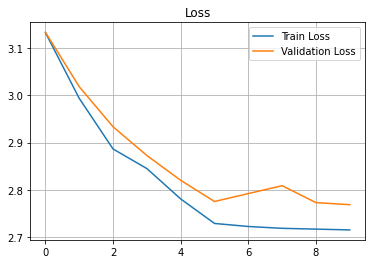

In [120]:
plt.title("Loss")
plt.plot(np.array(train_cost), label='Train Loss')
plt.plot(np.array(val_cost), label='Validation Loss')
plt.legend()
plt.grid()
plt.show()

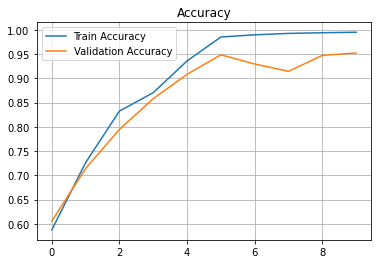

In [121]:
plt.title("Accuracy")
plt.plot(train_accu, label='Train Accuracy')
plt.plot(val_accu, label='Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

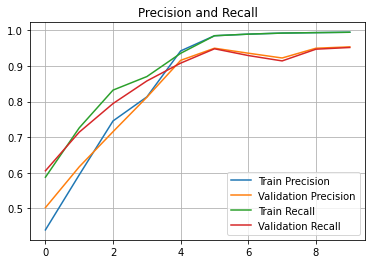

In [122]:
plt.title("Precision and Recall")
plt.plot(train_precisions, label='Train Precision')
plt.plot(val_precisions, label='Validation Precision')
plt.plot(train_recalls, label='Train Recall')
plt.plot(val_recalls, label='Validation Recall')
plt.legend()
plt.grid()
plt.show()

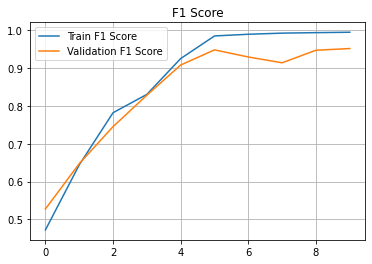

In [123]:
plt.title("F1 Score")
plt.plot(train_f1_scores, label='Train F1 Score')
plt.plot(val_f1_scores, label='Validation F1 Score')
plt.legend()
plt.grid()
plt.show()

#### 

In [54]:
y_test_true = []
y_test_pred = []
conf_mat_test = np.zeros(([39,39]))
total_batch_test = int(math.ceil(len(X_test) / BATCH_SIZE ))

model.eval()
for i, (Xtest,Ytest) in enumerate(test_dataloader):
    with torch.no_grad():
        X = Variable(Xtest).to(DEVICE)
        Y = Variable(Ytest).to(DEVICE)

        hypothesis = model(X)
        prediction = hypothesis.argmax(dim=1)
        y_test_pred = y_test_pred + list(prediction.to("cpu"))
        y_test_true = y_test_true + list(Ytest.to("cpu"))

    print_progress(i+1, total_batch_test, bins=50, before_msg="Testing: ", after_msg=None)

del X, Y
gc.collect()
torch.cuda.empty_cache()

print("\nAccuracy: ", 100 * ((torch.tensor(y_test_pred) == torch.tensor(y_test_true)).float().mean()).item())

for i in range(len(y_test_pred)):
    conf_mat_test[y_test_true[i], y_test_pred[i]] += 1

Testing:  1/397 [--------------------------------------------------]     

C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (128, 3, 128) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


Testing:  397/397 [##################################################]      

Accuracy:  95.14356851577759


 Apple___Apple_scab                                 | 89.40 
 Apple___Black_rot                                  | 96.62 
 Apple___Cedar_apple_rust                           | 99.85 
 Apple___healthy                                    | 99.08 
 Background_without_leaves                          | 98.62 
 Blueberry___healthy                                | 97.54 
 Cherry___Powdery_mildew                            | 96.62 
 Cherry___healthy                                   | 97.39 
 Corn___Cercospora_leaf_spot Gray_leaf_spot         | 94.16 
 Corn___Common_rust                                 | 97.39 
 Corn___Northern_Leaf_Blight                        | 82.49 
 Corn___healthy                                     | 100.00 
 Grape___Black_rot                                  | 95.55 
 Grape___Esca_(Black_Measles)                       | 99.08 
 Grape___Leaf_blight_(Isariopsis_Leaf_Spot)         | 99.85 
 Grape___healthy                                    | 98.77 
 Orange___Haunglongbing

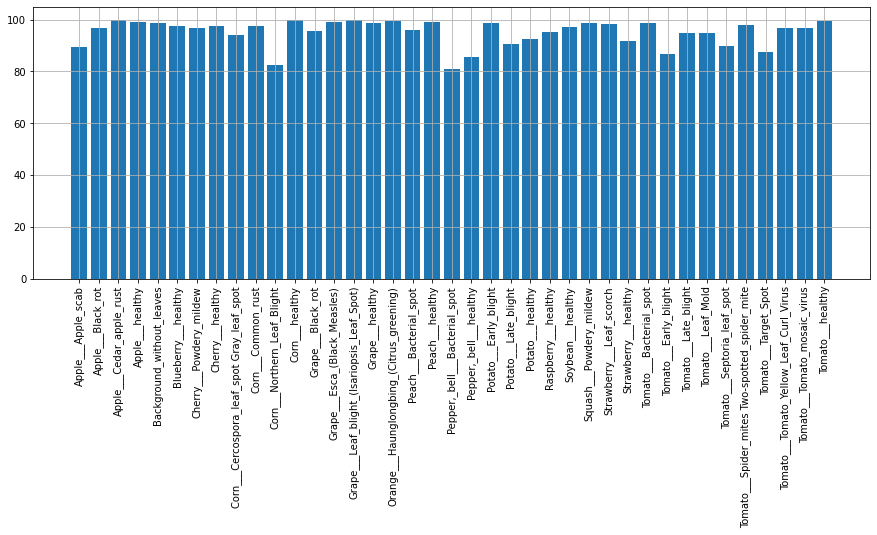

In [87]:
accu_per_class = {}
for i,x in enumerate(conf_mat_test):
    print(" {:<50} | {:2.2f} ".format(unique_labels[i], 100*x[i]/x.sum()))
    accu_per_class[unique_labels[i]] = 100*x[i]/x.sum()

# fig, ax1 = plt.subplots(figsize=(15, 5))
# ax1.bar(range(len(accu_per_class)), list(accu_per_class.values()), align='center')
# ax1.set_xticklabels(list(accu_per_class.keys()), rotation="vertical")
# plt.show()

fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.bar(x=range(len(unique_labels)), height=list(accu_per_class.values()), tick_label=unique_labels)
ax1.set_xticklabels(unique_labels, rotation=90)
plt.grid()
plt.show()

In [57]:
cm = confusion_matrix(y_test_pred, y_test_true)
cm.shape

C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys
C:\Users\kjpoo\anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


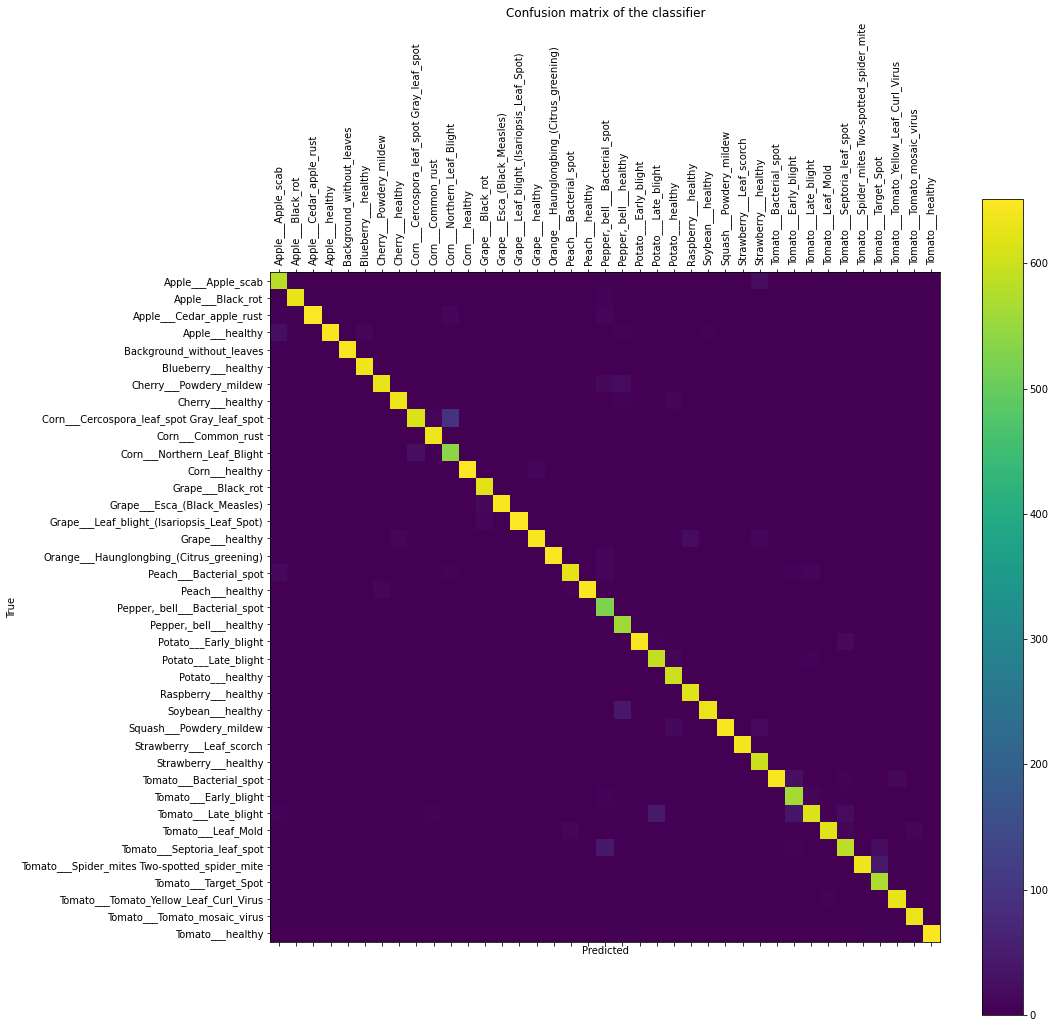

In [59]:
fig, ax = plt.subplots(figsize=(15, 15))
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([" "] + list(unique_labels),rotation="vertical")
ax.set_yticklabels([" "] + list(unique_labels))
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [74]:
print("precision: %.4f"%(precision_score(y_test_pred, y_test_true, average="macro")))

precision: 0.9514


In [75]:
print("Recall: %.4f"%(recall_score(y_test_pred, y_test_true, average="macro")))

Recall: 0.9536


In [77]:
print("F1_score: %.4f"%(f1_score(y_test_pred, y_test_true, average="macro")))

F1_score: 0.9513
